# Comp Screening - cell painting compressed (OG316) analysis
## FOR COMPLTETE (datalock) cell painting dataset
#### _BEM 10-19-2021_

### What this does:
looks @ the compressed screen data - tries out

In [1]:
import os
import sys
import warnings
import random
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import multiprocess as mp
from itertools import repeat
from scipy.stats import mode
from sklearn.metrics import silhouette_score
from sklearn.covariance import EmpiricalCovariance
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.multitest import multipletests

pd.set_option('mode.chained_assignment', None)
data_path = '../1_Data/'

## Define Functions

#### Hide annoying prints

In [3]:
class HiddenPrints:
    """
    Class to hide unnecessary prints
    """
    
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

#### Mahalanobis calcs

In [4]:
def mahala_dist_CS(adata, use_rep='X', std_cutoff=3, n_sample=10000, assume_centered=False, num_pcs=None):
    """
    Calculates the mahalanobis disance of the pert. avg and provides a standard deviation cutoff based on DMSO null dist
    in adata using MCD robust estimator trained on DMSO + avg Pert., stores values as metadata
    """
    
    # weight PCs by variance explained
    adata.obsm['X_pca_weighted'] = np.multiply(adata.obsm['X_pca'],adata.uns['pca']['variance_ratio'])
    adata.obsm['X_pca_harmony_weighted'] = np.multiply(adata.obsm['X_pca_harmony'],adata.uns['pca']['variance_ratio'])
    
    # select data
    adata_DMSO = adata[adata.obs.Metadata_perturbation=='DMSO',:]
    adata_pert = adata[~(adata.obs.Metadata_perturbation=='DMSO'),:]
    
    if use_rep == 'X':
        X_DMSO = adata_DMSO.X
        X_pert = pd.DataFrame()

        for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
            pert = pd.DataFrame(np.multiply(adata_pert.X, adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
            pert = pert.loc[~(pert==0).all(axis=1)]
            pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
            pert = pert.set_index('Metadata_perturbation')
            X_pert = pd.concat([X_pert, pert])

    elif use_rep == 'X_pca':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
            
    elif use_rep == 'X_pca_harmony':
        if num_pcs == None:
            print('speficy num_pcs')
            return
        else:
            X_DMSO = adata_DMSO.obsm['X_pca_harmony_weighted'][:,0:num_pcs]
            X_pert = pd.DataFrame()

            for i in list(range(adata_pert.obsm['design_matrix'].shape[1])):
                pert = pd.DataFrame(np.multiply(adata_pert.obsm['X_pca_harmony_weighted'][:,0:num_pcs], 
                                                adata_pert.obsm['design_matrix'][:,i].astype(int)[:, np.newaxis]))
                pert = pert.loc[~(pert==0).all(axis=1)]
                pert['Metadata_perturbation'] = adata_pert.uns['design_matrix_perturbations'][i]
                pert = pert.set_index('Metadata_perturbation')
                X_pert = pd.concat([X_pert, pert])
    
    else:
        print('use_rep is not valid option')
        return
    
    # average by perturbation
    X_avg_pert = X_pert.groupby('Metadata_perturbation').mean()

    # fit covariance estimator to control + avg. pert. sample
    cov = EmpiricalCovariance(assume_centered=assume_centered).fit(X_DMSO)

    # calclute perturbation mahalanois distances
    if assume_centered:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert))
    else:
        pert_mahal = np.sqrt(cov.mahalanobis(X_avg_pert-cov.location_))
    
    # sample DMSO null distribution
    n_rep = mode(X_pert.iloc[:,0].groupby('Metadata_perturbation').count()).mode[0]
    n_DMSO = len(X_DMSO)
    DMSO_null = np.mean(X_DMSO[np.random.randint(0,n_DMSO,size=(n_sample,n_rep))], axis=1)
    
    #calc DMSO null mahalanobis
    if assume_centered:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null))
    else:
        DMSO_mahal = np.sqrt(cov.mahalanobis(DMSO_null-cov.location_))
    
    # empirical stdev cutoff for pert vs. null DMSO
    pass_value = (np.std(DMSO_mahal)*std_cutoff)+np.mean(DMSO_mahal)
    
    # build pert table
    mahala_table = pd.DataFrame(pert_mahal, 
                                index=X_avg_pert.index,
                                columns=['mahalanobis'])
    mahala_table['signif_mahala'] = (pert_mahal > pass_value)
    mahala_table.reset_index(inplace=True)
    
    # make mahala table for plotting    
    dmso_table = pd.DataFrame(np.random.choice(DMSO_mahal, size=n_DMSO*5, replace=False),
                              columns=['mahalanobis'])
    dmso_table['Metadata_perturbation'] = 'DMSO'
    dmso_table['signif_mahala'] = 'DMSO'
    
    mahala_table = pd.concat([mahala_table, dmso_table])
    
    return mahala_table    

## Analysis

### Load in anndata

In [2]:
# PCA harmony data
OG316 = anndata.read_h5ad(data_path+'09272021_PCH_rd_OG316_table.h5ad')

# add metadata for landmarks
LM_list = ['DMSO','Doxorubicin','Daunorubicin','Fluvastatin','Ticlopidine',
           'Tropicamide','Mycophenolic Acid','Vinblastine Sulfate','Riluzole']

LM_df = pd.DataFrame(columns = LM_list)

for LM in LM_list:
    LM_df[LM] = (OG316.obs.Metadata_perturbation == LM)
    LM_df[LM] = OG316.obs.Metadata_perturbation[(OG316.obs.Metadata_perturbation == LM)]

    OG316.obs[LM] = LM_df[LM]

OG316.obs['landmarks'] = LM_df.astype(str).replace('nan', '').sum(axis=1)
OG316.obs.loc[OG316.obs.landmarks == '', 'landmarks'] = np.nan

# Add feature descriptors
feature_desc = pd.DataFrame(list(OG316.var_names))[0].str.split('_', n=2, expand=True)
feature_desc.columns = ['compartment','measure','channel']
feature_desc['channel'] = feature_desc.channel.str.split('_', expand=False).str.get(1)

OG316.var['compartment'] = feature_desc.compartment.values
OG316.var['measure'] = feature_desc.measure.values
OG316.var['channel'] = feature_desc.channel.values
OG316.var.loc[OG316.var.channel.isna(), 'channel'] = OG316.var.loc[OG316.var.channel.isna(), 'measure']
digits = ['0','1','2','3','4', '5', '6', '7', '8', '9']
OG316.var.loc[OG316.var.channel.isin(digits), 'channel'] = OG316.var.loc[OG316.var.channel.isin(digits), 'measure']
OG316.var.loc[OG316.var.channel == 'Adjacent', 'channel'] = OG316.var.loc[OG316.var.channel == 'Adjacent', 'measure']

# filter to only compressed data
C316 = OG316[~OG316.obs.Metadata_run.isin(['GT_run2', 'GT_run1_batch1']),:]


In [3]:
# filter to single run & add design matrix

r1_4x5r = C316[(C316.obs.Metadata_run=='CS_run1')&\
               (C316.obs.Metadata_perturbation.isin(['random', 'DMSO']))&\
               (C316.obs.Metadata_compression==4)&\
               (C316.obs.Metadata_replicates==5),:]

r1_4x5r.obs['design_index']=r1_4x5r.obs.Metadata_Plate.astype(str)+'_'+r1_4x5r.obs.Metadata_Well.astype(str)

# load in design matricies
run1_design = pd.read_csv(data_path+'CS_run1_PCH_rd_OG316_design_matrix.csv',index_col=0).reset_index().rename(columns={'index':'design_index'})

# add design matrix
design_mat = pd.DataFrame(r1_4x5r.obs['design_index']).\
             merge(run1_design,how='left',on='design_index').\
             drop(['design_index'],axis=1)

r1_4x5r.obsm['design_matrix']=np.array(design_mat)
r1_4x5r.uns['design_matrix_perturbations'] = design_mat.columns.values.tolist()

# filter to reps
plate = list(set(r1_4x5r.obs.loc[r1_4x5r.obs.Metadata_perturbation=='random','Metadata_Plate'].values))

r1_4x5r1 = r1_4x5r[(r1_4x5r.obs.Metadata_Plate==plate[0]),:]

Trying to set attribute `.obs` of view, copying.


### Determine num_PCs, neighbors, UMAP

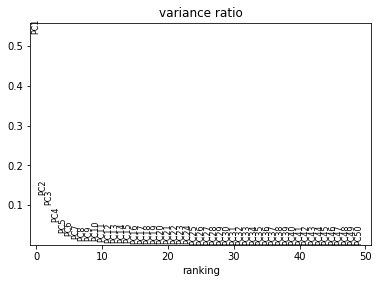

90% of variance explained by 9 PCs


In [4]:
# recalc PC's for dataset
sc.pp.pca(r1_4x5r1)

# single plate (no need to batch correct)

# get num of PCs to use (up to 90% var explained)
sc.pl.pca_variance_ratio(r1_4x5r1, n_pcs = 50, log=False)
num_pcs = sum(np.cumsum(r1_4x5r1.uns['pca']['variance_ratio']) < 0.9)+1

print('90% of variance explained by '+str(num_pcs)+' PCs')

### Determine Signif Pertrubs by Mahalnobis Dist

In [18]:
mahala_table = mahala_dist_CS(r1_4x5r1, std_cutoff=8, use_rep='X_pca', num_pcs=num_pcs)

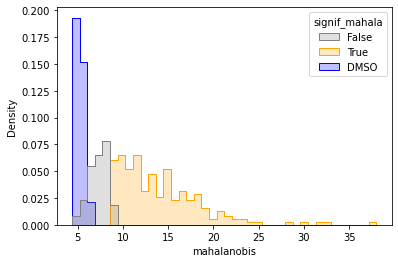

In [19]:
g = sns.histplot(mahala_table, x='mahalanobis', 
                 element="step", multiple='layer', stat='density', bins = 40,
                 hue="signif_mahala", palette=['grey','orange', 'blue'])

g.figure.savefig("figures/CS316_r1_4x5r_mahala_sig_plot.pdf");

In [20]:
sig_drugs = set(mahala_table.loc[mahala_table.signif_mahala==True,'Metadata_perturbation'].values)

print(str(len(sig_drugs))+' significant drugs')

pd.DataFrame({'mahala_sig_compounds':list(sig_drugs)}).to_csv('CS316_mahala_sig.csv', index=False)
mahala_table.to_csv('CS316_mahala.csv', index=False)


221 significant drugs
